In [1]:
# importing the dependencies
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import gensim
import gensim.downloader
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, SimpleRNN, Flatten, GlobalMaxPool1D
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.initializers import Constant

### Preprocessing the data 


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

train_df = train_df.drop(columns=['label-fine'])
test_df = test_df.drop(columns=['label-fine'])

# Creating developmental set of 500 rows from train set
train_df, dev_df = train_test_split(train_df, test_size=(500/len(train_df)), random_state=42)

counts = train_df['label-coarse'].value_counts()

# Find the labels with the lowest frequencies
lowest_frequency = [counts.index[-1], counts.index[-2]]
print("Labels being merged to new category: ", lowest_frequency)
print("Merged into new category: ", lowest_frequency[0])

# Replace these labels with new label: 6
train_df.loc[(train_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]
dev_df.loc[(dev_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]
test_df.loc[(test_df['label-coarse'].isin(lowest_frequency)), 'label-coarse'] = lowest_frequency[0]

train_df.reset_index(drop=True, inplace=True)
dev_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Labels being merged to new category:  [2, 5]
Merged into new category:  2


In [3]:
train_df

,label-coarse,text
0,2,What is Mikhail Gorbachev 's middle initial ?
1,0,How does the tail affect the flight of a kite ?
2,2,What were the first three cities to have a pop...
3,1,What is the movie Jonathan Livingstone Seagull ?
4,1,What is a fear of home surroundings ?
...,...,...
4947,4,How much Coca Cola is drunk in one day in the ...
4948,2,What cathedral was Thomas Becket murdered in ?
4949,3,What character in The Beverly Hillbillies has ...
4950,2,What does the River Seine empty into ?


In [4]:
# Takes about ~30 mins for first run, ~30 seconds afterwards
word2vec = gensim.downloader.load('word2vec-google-news-300')

In [5]:
train_df['text'][0]

"What is Mikhail Gorbachev 's middle initial ?"

In [6]:
# Tokenize the text using word_tokenize
train_df['text'] = train_df['text'].apply(word_tokenize)
dev_df['text'] = dev_df['text'].apply(word_tokenize)
test_df['text'] = test_df['text'].apply(word_tokenize)

In [7]:
train_df['text'][0]

['What', 'is', 'Mikhail', 'Gorbachev', "'s", 'middle', 'initial', '?']

In [8]:
# Count total number of unique tokens in the training data 
unique_tokens = set()
train_df['text'].apply(unique_tokens.update)
# Remove words from the set which are not in the word2vec model
unique_tokens = unique_tokens.intersection(set(word2vec.key_to_index.keys()))
len(unique_tokens)

8170

In [9]:
tok = Tokenizer()
tok.fit_on_texts(train_df['text'])
train_df['text'] = tok.texts_to_sequences(train_df['text'])
dev_df['text'] = tok.texts_to_sequences(dev_df['text'])
test_df['text'] = tok.texts_to_sequences(test_df['text'])

In [10]:
train_df['text'][0]

[3, 4, 1435, 1091, 10, 461, 3214, 1]

In [11]:
X_train_sequences = train_df['text']
X_dev_sequences = dev_df['text']
X_test_sequences = test_df['text']

max_len = max([len(sentence) for sentence in train_df['text']])

# Pad sequences to a fixed length (if needed)
X_train_padded = pad_sequences(X_train_sequences, maxlen= max_len, padding='post', truncating='post')
X_dev_padded = pad_sequences(X_dev_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

# Get the y labels
y_train = train_df['label-coarse']
y_dev = dev_df['label-coarse']
y_test = test_df['label-coarse']

# Convert the labels to categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

In [12]:
X_train_padded[0], y_train[0]

(array([   3,    4, 1435, 1091,   10,  461, 3214,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0], dtype=int32),
 array([0., 0., 1., 0., 0.], dtype=float32))

In [13]:
embedding_dim = len(word2vec['apple']) # Any word vector dimensionality

In [14]:
# Create a dictionary with the unqiue_tokens with the tokens as keys and interger values as values
word_index = {}
for i, token in enumerate(unique_tokens):
    word_index[token] = i

In [15]:
vocab_size = len(word_index) + 1

In [16]:
embedding_matrix = np.zeros(shape=(vocab_size, embedding_dim))

for word, i in word_index.items():
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [17]:
num_epochs = [10, 20]
batch_sizes = [32, 64, 128]
learning_rates = [0.001]

In [18]:
# Perform hyperparameter optimization

class AccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []
    
    def on_epoch_end(self, epoch, logs={}):
        self.train_accuracies.append(logs.get('accuracy'))
        self.eval_accuracies.append(logs.get('val_accuracy'))

accuracies = {}
test_accuracy = {}

for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            # Initialize the list to store the training and eval accuracies 
            accuracy_callback = AccuracyCallback()
            accuracies[(num_epoch, batch_size, learning_rate)] = accuracy_callback

            model = Sequential([
                Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, embeddings_initializer=Constant(embedding_matrix), trainable=False),
                SimpleRNN(512, return_sequences=True),
                Dropout(0.2),
                SimpleRNN(128, return_sequences=True),
                Dropout(0.2),
                GlobalMaxPool1D(), 
                Dense(5, activation='softmax')
            ])

            # Train and store the accuracies
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
            model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
            model.fit(X_train_padded, y_train, epochs=num_epoch, batch_size=batch_size, validation_data=(X_dev_padded, y_dev), callbacks=[accuracy_callback])

            # Evaluate the model on the test data
            loss, accuracy = model.evaluate(X_test_padded, y_test)
            test_accuracy[(num_epoch, batch_size, learning_rate)] = accuracy

Epoch 1/10
155/155 [==============================] - 7s 42ms/step - loss: 1.0526 - accuracy: 0.5751 - val_loss: 0.9177 - val_accuracy: 0.6340
Epoch 2/10
155/155 [==============================] - 7s 44ms/step - loss: 0.8656 - accuracy: 0.6597 - val_loss: 0.8638 - val_accuracy: 0.6660
Epoch 3/10
155/155 [==============================] - 7s 44ms/step - loss: 0.8343 - accuracy: 0.6765 - val_loss: 1.0496 - val_accuracy: 0.5280
Epoch 4/10
155/155 [==============================] - 7s 45ms/step - loss: 1.0531 - accuracy: 0.5602 - val_loss: 1.1825 - val_accuracy: 0.5620
Epoch 5/10
155/155 [==============================] - 7s 46ms/step - loss: 0.9920 - accuracy: 0.5923 - val_loss: 1.0870 - val_accuracy: 0.5720
Epoch 6/10
155/155 [==============================] - 8s 49ms/step - loss: 0.9527 - accuracy: 0.6177 - val_loss: 1.0083 - val_accuracy: 0.6340
Epoch 7/10
155/155 [==============================] - 7s 42ms/step - loss: 1.0632 - accuracy: 0.5571 - val_loss: 1.1757 - val_accuracy: 0.5860

Epoch 1/10
78/78 [==============================] - 5s 62ms/step - loss: 1.0377 - accuracy: 0.5838 - val_loss: 0.9276 - val_accuracy: 0.6220
Epoch 2/10
78/78 [==============================] - 5s 68ms/step - loss: 0.9360 - accuracy: 0.6365 - val_loss: 0.9917 - val_accuracy: 0.5980
Epoch 3/10
78/78 [==============================] - 5s 69ms/step - loss: 0.8376 - accuracy: 0.6765 - val_loss: 0.8130 - val_accuracy: 0.6840
Epoch 4/10
78/78 [==============================] - 5s 68ms/step - loss: 0.7961 - accuracy: 0.6945 - val_loss: 0.8675 - val_accuracy: 0.6760
Epoch 5/10
78/78 [==============================] - 5s 61ms/step - loss: 0.7271 - accuracy: 0.7225 - val_loss: 0.8093 - val_accuracy: 0.6960
Epoch 6/10
78/78 [==============================] - 5s 60ms/step - loss: 0.6689 - accuracy: 0.7421 - val_loss: 0.7397 - val_accuracy: 0.7100
Epoch 7/10
78/78 [==============================] - 5s 62ms/step - loss: 0.6406 - accuracy: 0.7538 - val_loss: 0.7938 - val_accuracy: 0.6780
Epoch 8/10
78

Epoch 1/10
39/39 [==============================] - 5s 114ms/step - loss: 1.1585 - accuracy: 0.5448 - val_loss: 0.9154 - val_accuracy: 0.6400
Epoch 2/10
39/39 [==============================] - 4s 106ms/step - loss: 0.8178 - accuracy: 0.6862 - val_loss: 0.8149 - val_accuracy: 0.6740
Epoch 3/10
39/39 [==============================] - 5s 124ms/step - loss: 0.7450 - accuracy: 0.7157 - val_loss: 0.8068 - val_accuracy: 0.6820
Epoch 4/10
39/39 [==============================] - 6s 146ms/step - loss: 0.6681 - accuracy: 0.7456 - val_loss: 0.7400 - val_accuracy: 0.7060
Epoch 5/10
39/39 [==============================] - 7s 178ms/step - loss: 0.6316 - accuracy: 0.7617 - val_loss: 0.7343 - val_accuracy: 0.7280
Epoch 6/10
39/39 [==============================] - 12s 304ms/step - loss: 0.6111 - accuracy: 0.7728 - val_loss: 0.7317 - val_accuracy: 0.7220
Epoch 7/10
39/39 [==============================] - 14s 371ms/step - loss: 0.5616 - accuracy: 0.7932 - val_loss: 0.6742 - val_accuracy: 0.7420
Epoc

Epoch 1/20
155/155 [==============================] - 12s 69ms/step - loss: 1.0906 - accuracy: 0.5668 - val_loss: 1.0827 - val_accuracy: 0.6020
Epoch 2/20
155/155 [==============================] - 11s 69ms/step - loss: 1.0277 - accuracy: 0.5872 - val_loss: 1.5928 - val_accuracy: 0.2180
Epoch 3/20
155/155 [==============================] - 10s 66ms/step - loss: 1.0141 - accuracy: 0.5862 - val_loss: 0.9799 - val_accuracy: 0.5920
Epoch 4/20
155/155 [==============================] - 10s 63ms/step - loss: 0.8914 - accuracy: 0.6474 - val_loss: 0.9213 - val_accuracy: 0.6380
Epoch 5/20
155/155 [==============================] - 10s 66ms/step - loss: 0.8149 - accuracy: 0.6781 - val_loss: 0.8712 - val_accuracy: 0.6620
Epoch 6/20
155/155 [==============================] - 10s 62ms/step - loss: 0.8249 - accuracy: 0.6848 - val_loss: 0.8809 - val_accuracy: 0.6520
Epoch 7/20
155/155 [==============================] - 10s 63ms/step - loss: 0.8649 - accuracy: 0.6575 - val_loss: 0.9778 - val_accuracy:

Epoch 1/20
78/78 [==============================] - 6s 76ms/step - loss: 1.1406 - accuracy: 0.5416 - val_loss: 0.9667 - val_accuracy: 0.6080
Epoch 2/20
78/78 [==============================] - 6s 75ms/step - loss: 0.8819 - accuracy: 0.6597 - val_loss: 0.8931 - val_accuracy: 0.6360
Epoch 3/20
78/78 [==============================] - 6s 79ms/step - loss: 0.9175 - accuracy: 0.6452 - val_loss: 0.9260 - val_accuracy: 0.6380
Epoch 4/20
78/78 [==============================] - 6s 75ms/step - loss: 0.8137 - accuracy: 0.6886 - val_loss: 0.8509 - val_accuracy: 0.6720
Epoch 5/20
78/78 [==============================] - 6s 76ms/step - loss: 0.7418 - accuracy: 0.7134 - val_loss: 0.7596 - val_accuracy: 0.7320
Epoch 6/20
78/78 [==============================] - 7s 84ms/step - loss: 0.6873 - accuracy: 0.7379 - val_loss: 0.7377 - val_accuracy: 0.7080
Epoch 7/20
78/78 [==============================] - 6s 75ms/step - loss: 0.6646 - accuracy: 0.7470 - val_loss: 0.7990 - val_accuracy: 0.7040
Epoch 8/20
78

Epoch 1/20
39/39 [==============================] - 5s 114ms/step - loss: 1.2248 - accuracy: 0.5293 - val_loss: 0.9376 - val_accuracy: 0.6320
Epoch 2/20
39/39 [==============================] - 4s 106ms/step - loss: 0.8639 - accuracy: 0.6648 - val_loss: 0.8266 - val_accuracy: 0.6840
Epoch 3/20
39/39 [==============================] - 4s 107ms/step - loss: 0.7989 - accuracy: 0.6933 - val_loss: 0.8559 - val_accuracy: 0.6800
Epoch 4/20
39/39 [==============================] - 4s 109ms/step - loss: 0.7511 - accuracy: 0.7120 - val_loss: 0.7479 - val_accuracy: 0.7140
Epoch 5/20
39/39 [==============================] - 5s 117ms/step - loss: 0.6786 - accuracy: 0.7365 - val_loss: 0.7473 - val_accuracy: 0.7220
Epoch 6/20
39/39 [==============================] - 4s 111ms/step - loss: 0.6200 - accuracy: 0.7682 - val_loss: 0.7325 - val_accuracy: 0.7240
Epoch 7/20
39/39 [==============================] - 4s 111ms/step - loss: 0.5724 - accuracy: 0.7884 - val_loss: 0.7244 - val_accuracy: 0.7280
Epoch 

In [19]:
test_accuracy

{(10, 32, 0.001): 0.6700000166893005,
 (10, 64, 0.001): 0.7860000133514404,
 (10, 128, 0.001): 0.828000009059906,
 (20, 32, 0.001): 0.6179999709129333,
 (20, 64, 0.001): 0.8080000281333923,
 (20, 128, 0.001): 0.7680000066757202}

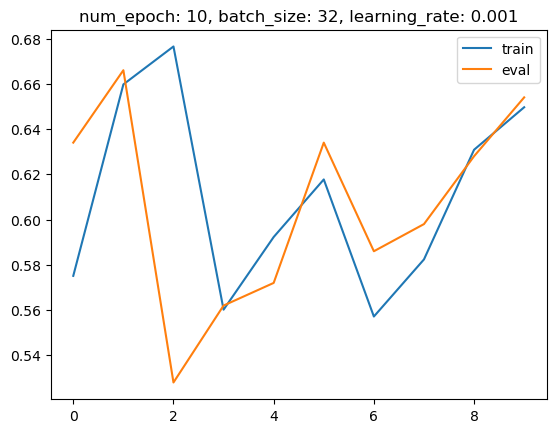

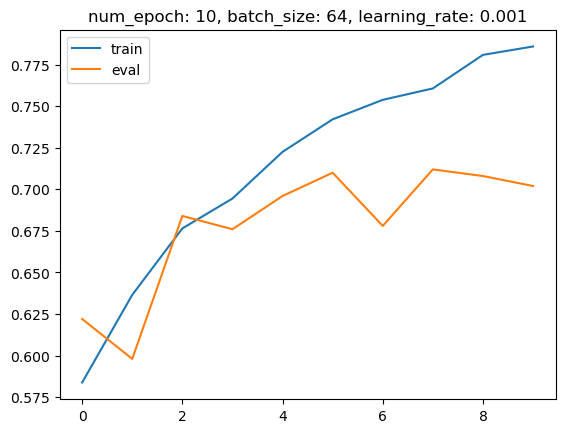

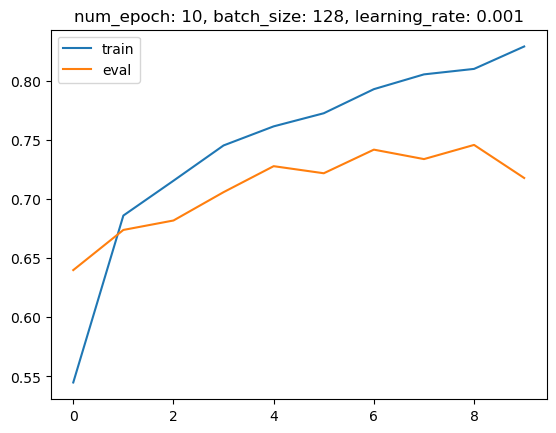

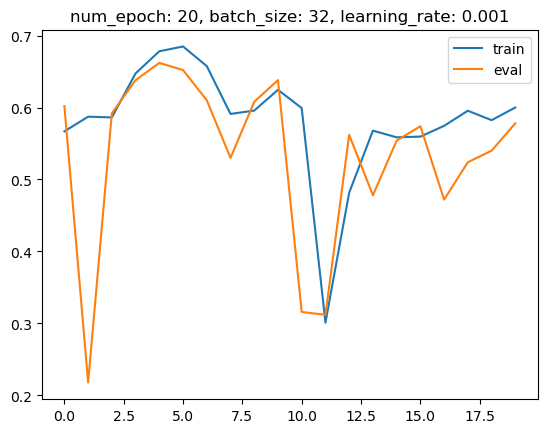

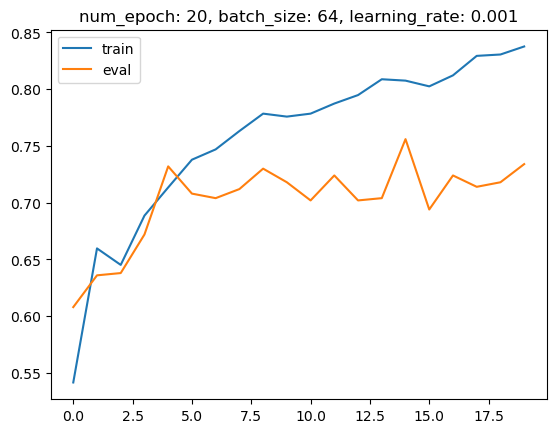

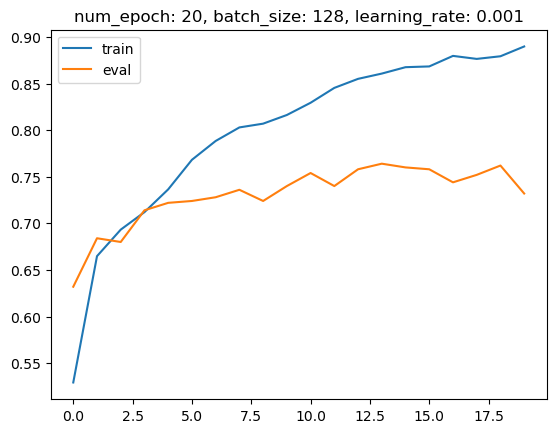

In [20]:
import matplotlib.pyplot as plt

# Plot the training and eval accuracies for each hyperparameter combination
for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            accuracy_callback = accuracies[(num_epoch, batch_size, learning_rate)]
            plt.plot(accuracy_callback.train_accuracies, label='train')
            plt.plot(accuracy_callback.eval_accuracies, label='eval')
            plt.title("num_epoch: {}, batch_size: {}, learning_rate: {}".format(num_epoch, batch_size, learning_rate))
            plt.legend()
            plt.show()

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'num_epoch: 10, batch_size: 32, learning_rate: 0.001'),
  Text(1, 0, 'num_epoch: 10, batch_size: 64, learning_rate: 0.001'),
  Text(2, 0, 'num_epoch: 10, batch_size: 128, learning_rate: 0.001'),
  Text(3, 0, 'num_epoch: 20, batch_size: 32, learning_rate: 0.001'),
  Text(4, 0, 'num_epoch: 20, batch_size: 64, learning_rate: 0.001'),
  Text(5, 0, 'num_epoch: 20, batch_size: 128, learning_rate: 0.001')])

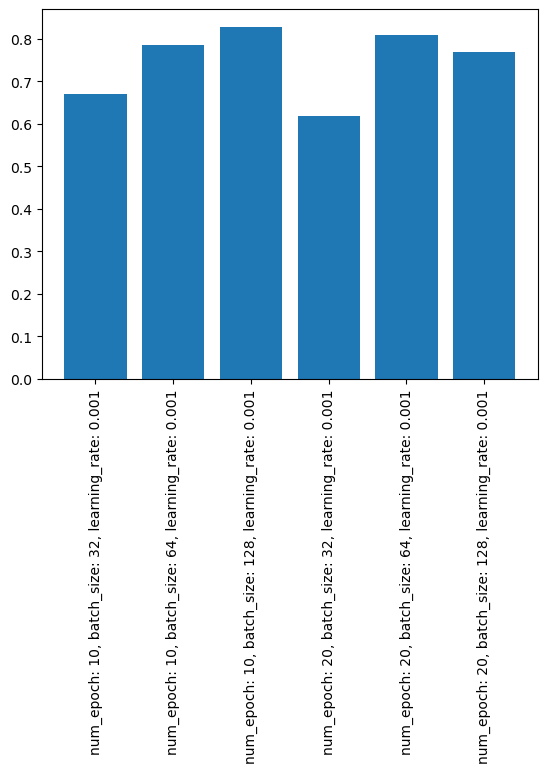

In [21]:
# Plot the test accuracies for each hyperparameter combination and label the x-axis accordingly
x_axis = []
y_axis = []
for num_epoch in num_epochs:
    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            x_axis.append("num_epoch: {}, batch_size: {}, learning_rate: {}".format(num_epoch, batch_size, learning_rate))
            y_axis.append(test_accuracy[(num_epoch, batch_size, learning_rate)])

# Make the x-axis labels vertical
plt.bar(x_axis, y_axis)
plt.xticks(rotation=90)